# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>




<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same answers
random.seed(42)

### 1.1  

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.nunique()['user_id']

290584

**d.** The proportion of users converted.

In [5]:
df.query('converted == 1').shape[0] / df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0] + df.query("group != 'treatment' and landing_page == 'new_page'").shape[0]

3893

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**There is no missing values in the dataset.**

### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** Now use the answer to create a new dataset that meets the specifications.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
drop_index = df.query("landing_page == 'new_page' and group == 'control'").index
drop_index2 = df.query("landing_page == 'old_page' and group == 'treatment'").index
total_dropindex = drop_index.append(drop_index2)
df2= df.drop(total_dropindex)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()['user_id']

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

In [14]:
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

### 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br>

In [15]:
p_population = df2.query("converted == 1").shape[0] / df2.shape[0]
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_control = df2.query("converted == 1 and group == 'control'").shape[0] / df2.query("group == 'control'").shape[0]
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_treatment = df2.query("converted == 1 and group == 'treatment'").shape[0] / df2.query("group == 'treatment'").shape[0]
p_treatment

0.11880806551510564

**The probabilities we've computed in the points (b). and (c). above can also be treated as conversion rate. 
Now to calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. We will need that later.** 

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
df2.query("landing_page == 'new_page'").shape[0] / df2.shape[0]

0.5000619442226688

In [20]:
#probability that an individual received the old page
df2.query("landing_page == 'old_page'").shape[0] / df2.shape[0]

0.4999380557773312

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**The probability of an individual converting from Treatment group (11.88%) is slightly lower than the probability of an individual converting from Control group (12.04%), but we can notice that this small difference does not give enough evidence to support any of the two arguments.**

>**Also the test seems to be well balanced as almost half the population received the new page (0.5001) and the other half received the old page (0.4999).**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1
For now, consider we need to make the decision just based on all the data provided.  


If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  


1. $H_{0}$ : $P_{new}$ =< $P_{old}$     ($P_{new}$ - $P_{old}$ =< 0)
2. $H_{1}$ : $P_{new}$ > $P_{old}$     ($P_{new}$ - $P_{old}$ > 0)

# 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2.query("converted == 1").shape[0]/df2.shape[0]
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2.query("converted == 1").shape[0]/df2.shape[0]
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br>


In [23]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis. <br> Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.

In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],size=n_new,p=[(1-p_new),p_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],size=n_old,p=[(1-p_old),p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
conv_diff = new_page_converted.mean() - old_page_converted.mean()
conv_diff

0.00041766140101795468


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution using numpy .binomial function
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


Text(0,0.5,'Count')

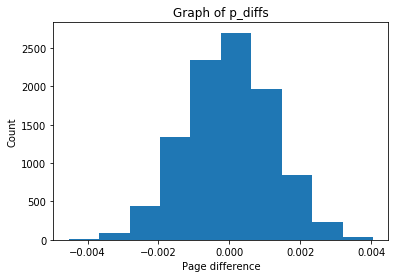

In [29]:
#plotting the data
plt.hist(p_diffs);

#adding title and x,y labels
plt.title('Graph of p_diffs')
plt.xlabel('Page difference')
plt.ylabel('Count')

In [30]:
# simulate distribution under the null hypothesis
null_hypoth = np.random.normal(loc=0, scale=p_diffs.std(), size=10000)

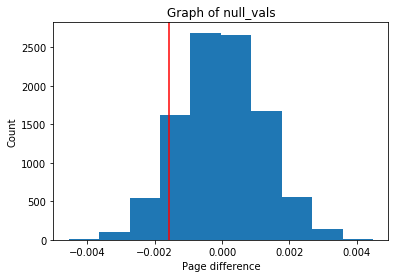

In [31]:
# plot null distribution
plt.hist(null_hypoth)

#adding title and x,y labels
plt.title('Graph of null_vals')
plt.xlabel('Page difference')
plt.ylabel('Count')

# plot line for actual difference
plt.axvline(x=obs_diff, color='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [32]:
# compute p value
(null_hypoth > obs_diff).mean()

0.90059999999999996

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?

>**This value is called the p-value.**
>
>**Since the Type I error rate being 0.05 and the computed p-value is greater than 0.05, therefore there is not enough evidence to reject the null hypothesis.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'").shape[0]

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'").shape[0]

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [35]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 




In [36]:
import statsmodels.api as sm
#Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print("Z score: ",z_score)
print("P-Value: ", p_value)

Z score:  -1.31092419842
P-Value:  0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br>



>**A Z-score describes deviation from the mean in units of standard deviation. While a p-value is the probability that under the null hypothesis we could observe a point that is as extreme as our statistic.**
>
>**Here we find that z-score is 1.31 which is less than z-critical value (1.6) and p-value is 0.905 which is greater than type I error threshold (0.05). Both results are considered strong reasons to support the null hypothesis. And they agree with our previous findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

### 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [37]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [38]:
import statsmodels.api as sm
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-21 12:18 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>  



>The null and alternative hypotheses in **Part II**:
>1. $H_{0}$ : $P_{new}$ - $P_{old}$ =< 0
>2. $H_{1}$ : $P_{new}$ - $P_{old}$ > 0
>
>The null and alternative hypotheses in **Regression model**:
>1. $H_{0}$ : $P_{new}$ - $P_{old}$ = 0
>2. $H_{1}$ : $P_{new}$ - $P_{old}$ != 0
>
>**The p-value for ab_page is 0.1899. and it is different from the p_value we deduced from part II. And it is also greater than the type 1 error value (0.05), so we fail to reject the null hypothesis.
The reason for the difference is because Logistic Regression is based on a two-tailed test.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Considering other factors that might have an influence on the conversion of individuals is a good thing as it helps to identify the potential causes that result in conversion.**
>
>**On the other hand, considering other factors might have disadvantages as well, as this will lead to levitating the complexity of the model, and in turn this added complexity can result in misinterpretation of the model or increasing the risk of human error occurence.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [40]:
# Read the 'countries.csv' file
countries = pd.read_csv('countries.csv')

countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
# Join with the df2 dataframe
df_merged = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 




In [43]:
# Fit the model
logistic_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA']])
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [44]:
#summarize the results
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-21 12:18 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
CA           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

In [45]:
#Add  interactions between page and country
df_merged['UK_new'] = df_merged['UK'] * df_merged['ab_page']
df_merged['CA_new'] = df_merged['CA'] * df_merged['ab_page']

df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA,UK_new,CA_new
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [46]:
# Fit the model
new_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA', 'UK_new', 'CA_new']])
new_results = new_model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [47]:
#summarize the results
new_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-21 12:18 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
UK           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
UK_new       -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
CA_new       -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

>**We find that the p-values here in this model are greater than 0.05 which means that countries appear to be not statistically significant for individuals' conversion, so we fail to reject the null hypothesis**

<a id='conclusion'></a>
## Conclusion

>**Based on this study, we find that we don't have enough evidence to reject the null hypothesis as all the p-values computed by different means are greater than the type I error threshold (0.05).**
>
>**so we think either we stick with the old page or we should let the experiment run for a longer time in order for data to lean in one direction or the other.**






In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0